In [12]:
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
from extract_data import extract_data_from_folder, parse_condition_intervals
import pandas as pd

In [25]:

SAMPLING_RATE = 51.2
GSR_COL = 'Shimmer_A679_GSR_Skin_Conductance_CAL'

def clean_eda(signal, sampling_rate=SAMPLING_RATE):
    # Detects incoherent spikes (values > 45) and replaces them with
    # linear interpolation between the samples just before and after the spike
    
    # In some cases the threshold is not enough, so we combine it with a 5x median
    # threshold. I have not seen a failure of this scheme but it might happen, so
    # if you get wierd peaks, might be worth looking into this
    median = np.median(signal)
    spike_mask = signal > min(45, median * 5)
    cleaned = signal.copy().astype(float)
    # Use pandas interpolation for clean linear fill
    cleaned[spike_mask] = np.nan
    cleaned = pd.Series(cleaned).interpolate(method='linear').values
    return cleaned


def compute_basic_eda_metrics(df):
    signals, _ = nk.eda_process(clean_eda(df[GSR_COL].values), sampling_rate=SAMPLING_RATE)
    #print(signals.tail())

    scr_peaks = signals['SCR_Peaks'] == 1
    scr_amps = signals.loc[scr_peaks, 'SCR_Amplitude']

    duration_min = len(signals) / SAMPLING_RATE / 60.0
    dt = 1.0 / SAMPLING_RATE
    phasic = signals['EDA_Phasic'].values

    return {
        'mean_tonic_uS':         signals['EDA_Tonic'].mean(),
        'mean_phasic_uS':        signals['EDA_Phasic'].mean(),
        'scr_count':             int(scr_peaks.sum()),
        'mean_scr_amp_uS':       scr_amps.mean() if len(scr_amps) > 0 else 0.0,
        'scr_peak_rate_per_min': scr_peaks.sum() / duration_min if duration_min > 0 else 0.0,
        'phasic_auc_abs_uS_s':   float(np.sum(np.abs(phasic)) * dt),
    }

def compute_all_metrics(all_subjects):
    rows = []
    for subject_id, subject_df in all_subjects.items():
        for (condition, rep), group in subject_df.groupby(['condition', 'rep']):
            try:
                m = compute_basic_eda_metrics(group)
                rows.append({'subject_id': subject_id, 'condition': condition, 'rep': rep, **m})
            except Exception as e:
                print(f"Failed {subject_id} {condition} rep{rep}: {e}")
    return pd.DataFrame(rows)

def plot_metric(subject_df, metric):
    rows = []
    for (condition, rep), group in subject_df.groupby(['condition', 'rep']):
        try:
            m = compute_basic_eda_metrics(group)
            rows.append({'label': f'{condition}_rep{rep}', 'value': m[metric]})
        except Exception as e:
            print(f"Failed {condition} rep{rep}: {e}")
            break

    df = pd.DataFrame(rows).set_index('label')
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(df.index, df['value'])
    ax.set_title(metric)
    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()

In [20]:
all_subjects = extract_data_from_folder()
#metrics = compute_metrics_df(all_subjects['67455'])
#plot_metric(metrics['mean_tonic_uS'], 'mean_tonic_uS')

Loaded 28949: 82019 rows
Loaded 48203: 90523 rows
Loaded 55131: 83403 rows
Loaded 63264: 86167 rows
Loaded 63817: 79571 rows
Loaded 67455: 75489 rows
Loaded 69316: 110232 rows
Loaded 81264: 76723 rows
Loaded 85418: 83356 rows
Loaded 9999999: 78631 rows


In [26]:
compute_basic_eda_metrics(all_subjects['67455'])

{'mean_tonic_uS': 5.931446806487367,
 'mean_phasic_uS': -4.35184751670784e-06,
 'scr_count': 5,
 'mean_scr_amp_uS': 0.498984667219278,
 'scr_peak_rate_per_min': 0.20347335373365655,
 'phasic_auc_abs_uS_s': 31.327868838927525}

In [44]:
metrics_df = compute_all_metrics(all_subjects)
metrics_df.tail()

subject_id condition  rep  mean_tonic_uS  mean_phasic_uS  scr_count  \
74    9999999  ES_empty    1       3.802948        0.000420         13   
75    9999999        NE    0       2.811300        0.000071         16   
76    9999999        NE    1       4.344013       -0.000103         21   
77    9999999  NE_empty    0       4.334915       -0.000001         22   
78    9999999  NE_empty    1       3.854918        0.000675         11   

    mean_scr_amp_uS  scr_peak_rate_per_min  phasic_auc_abs_uS_s  
74         0.154632               4.149195             6.218670  
75         0.050987               5.413812             3.225242  
76         0.085435               6.494715             4.679864  
77         0.071148               6.534274             6.467789  
78         0.323711               3.300000            12.355273

In [55]:
plot_metric(all_subjects['9999999'], 'scr_peak_rate_per_min')

KeyError: slice(None, None, None)

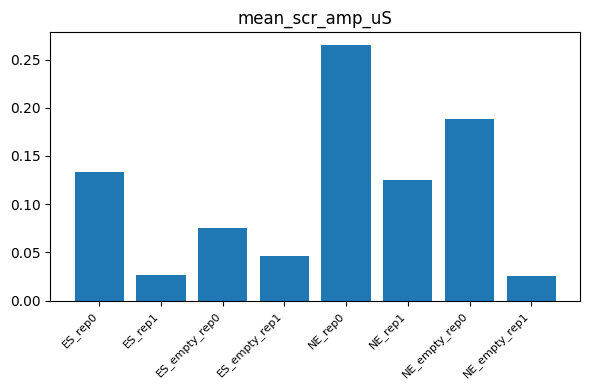

In [66]:
plot_metric(all_subjects['28949'], 'mean_scr_amp_uS')

# TODO: whisker plot (mean for all users)

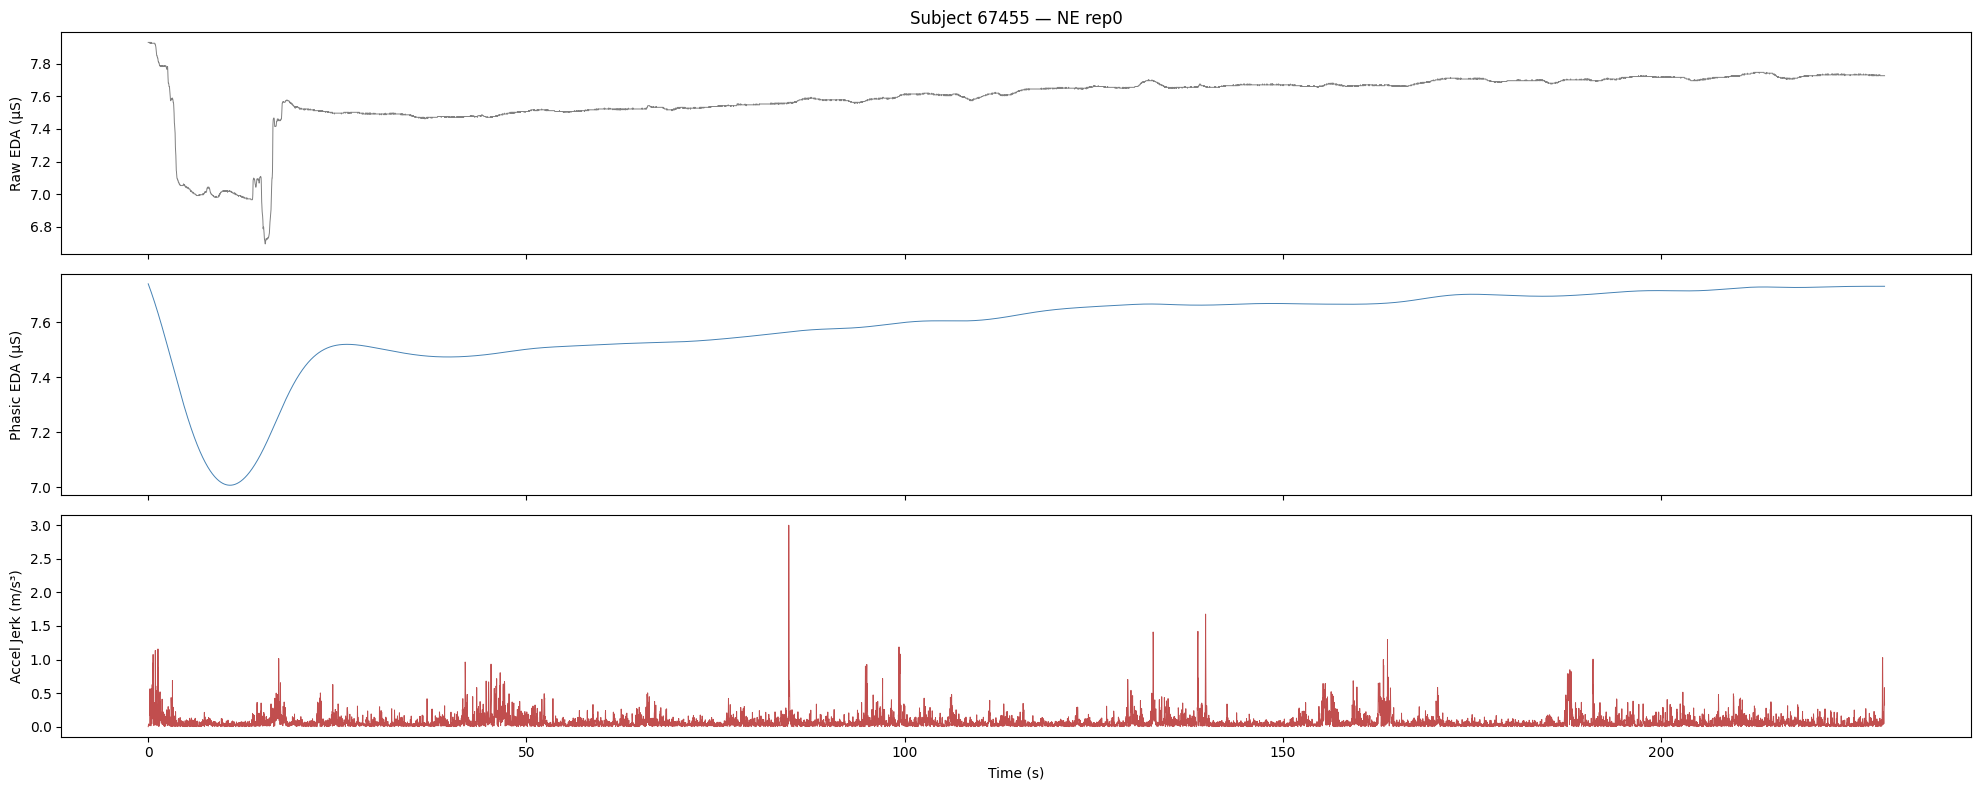

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

from scipy.signal import medfilt

def clean_eda(signal, sampling_rate=SAMPLING_RATE):
    # Detects incoherent spikes (values > 45) and replaces them with
    # linear interpolation between the samples just before and after the spike
    median = np.median(signal)
    spike_mask = signal > min(45, median * 5)
    cleaned = signal.copy().astype(float)
    # Use pandas interpolation for clean linear fill
    cleaned[spike_mask] = np.nan
    cleaned = pd.Series(cleaned).interpolate(method='linear').values
    return cleaned


subject_df = all_subjects['67455']
seg = subject_df[(subject_df['condition'] == 'NE') & (subject_df['rep'] == 0)]

# Accelerometer columns
accel_cols = [
    'Shimmer_A679_Accel_LN_X_CAL',
    'Shimmer_A679_Accel_LN_Y_CAL', 
    'Shimmer_A679_Accel_LN_Z_CAL',
]

# Compute accelerometer magnitude (jerk = derivative of accel)
accel = seg[accel_cols].values
accel_mag = np.sqrt((accel ** 2).sum(axis=1))
jerk = np.abs(np.diff(accel_mag, prepend=accel_mag[0]))

# Clean + process EDA
raw_eda = seg[GSR_COL].values
cleaned_eda = clean_eda(raw_eda)
raw_eda = cleaned_eda
signals, _ = nk.eda_process(cleaned_eda, sampling_rate=SAMPLING_RATE)
phasic = signals['EDA_Tonic'].values

t = np.arange(len(seg)) / SAMPLING_RATE

fig, axes = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

axes[0].plot(t, raw_eda, color='gray', linewidth=0.7)
axes[0].set_ylabel('Raw EDA (µS)')
axes[0].set_title('Subject 67455 — NE rep0')

axes[1].plot(t, phasic, color='steelblue', linewidth=0.7)
axes[1].set_ylabel('Phasic EDA (µS)')

axes[2].plot(t, jerk, color='firebrick', linewidth=0.7, alpha=0.8)
axes[2].set_ylabel('Accel Jerk (m/s³)')
axes[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [8]:
# per subject, per condition
#  - phasic (all curves)
#  - tonic (all curves)

# All subjects
# - differentiate color by condition 

In [9]:
#- empty vs nE
#- N vs ES

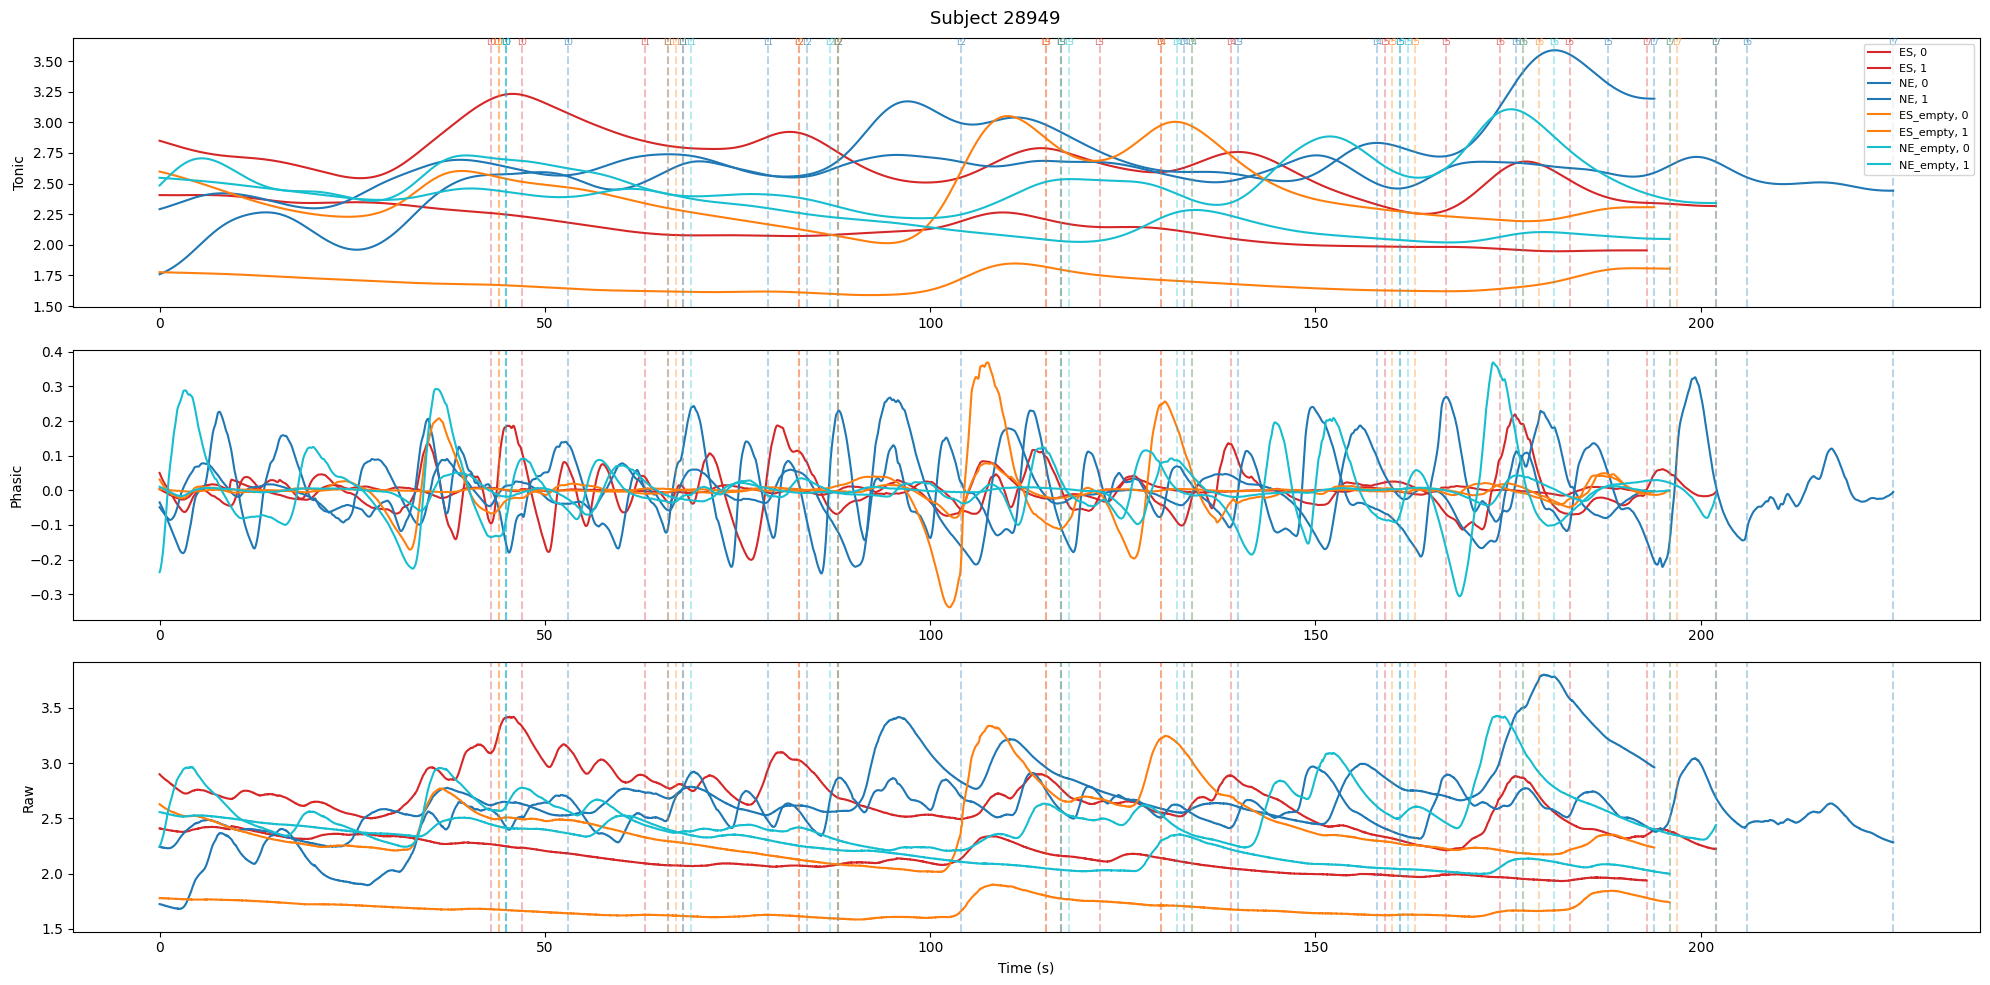

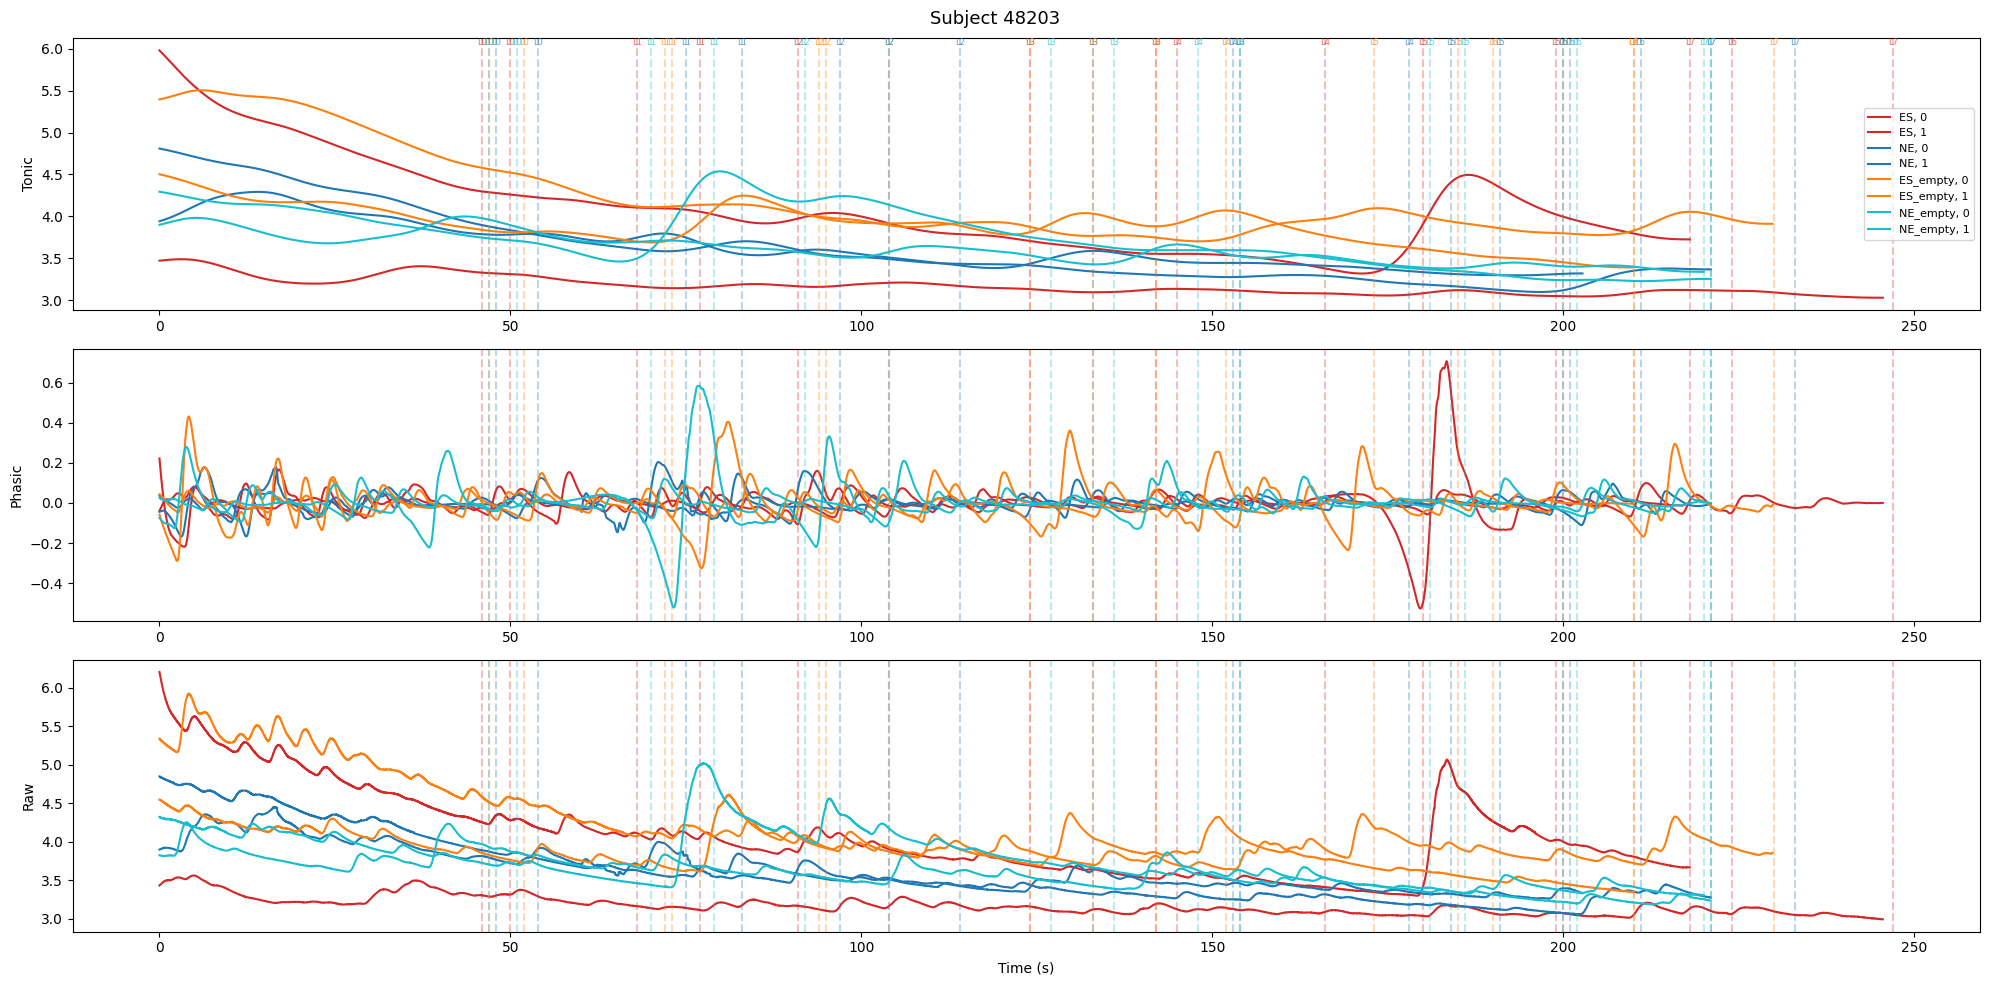

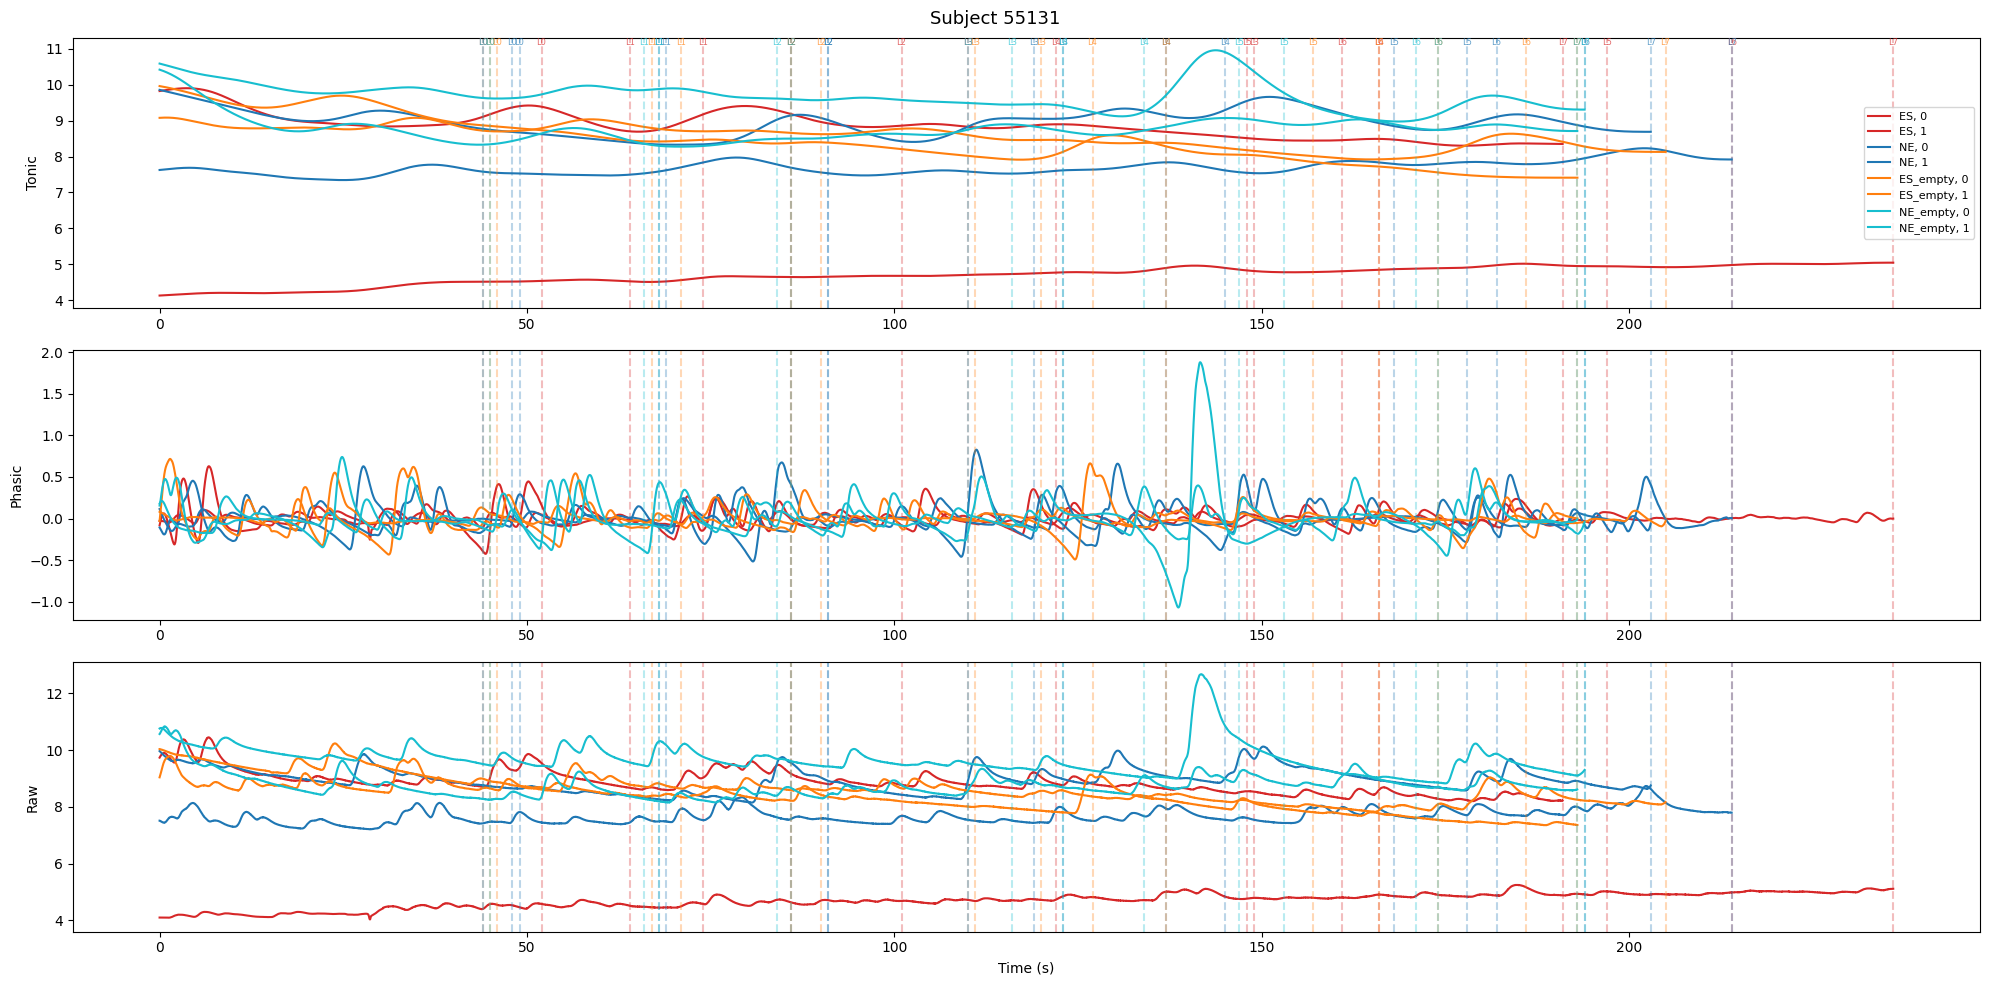

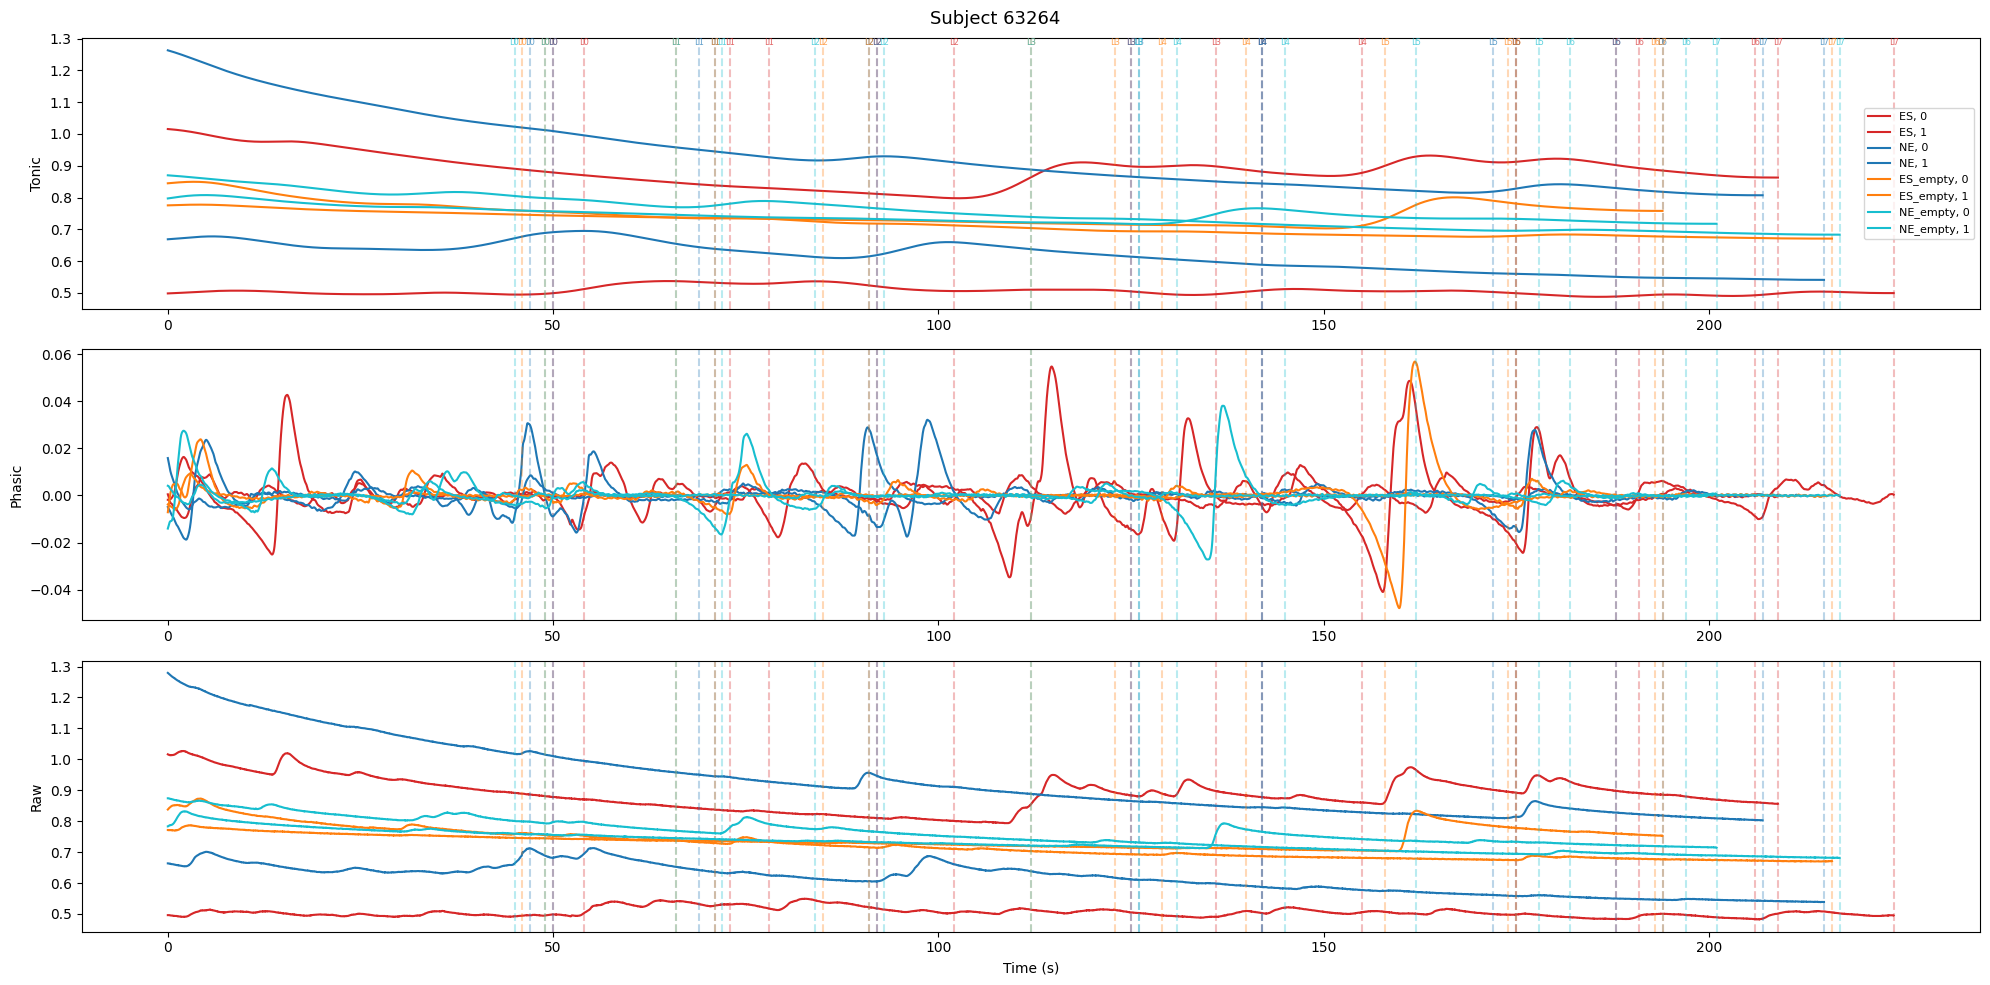

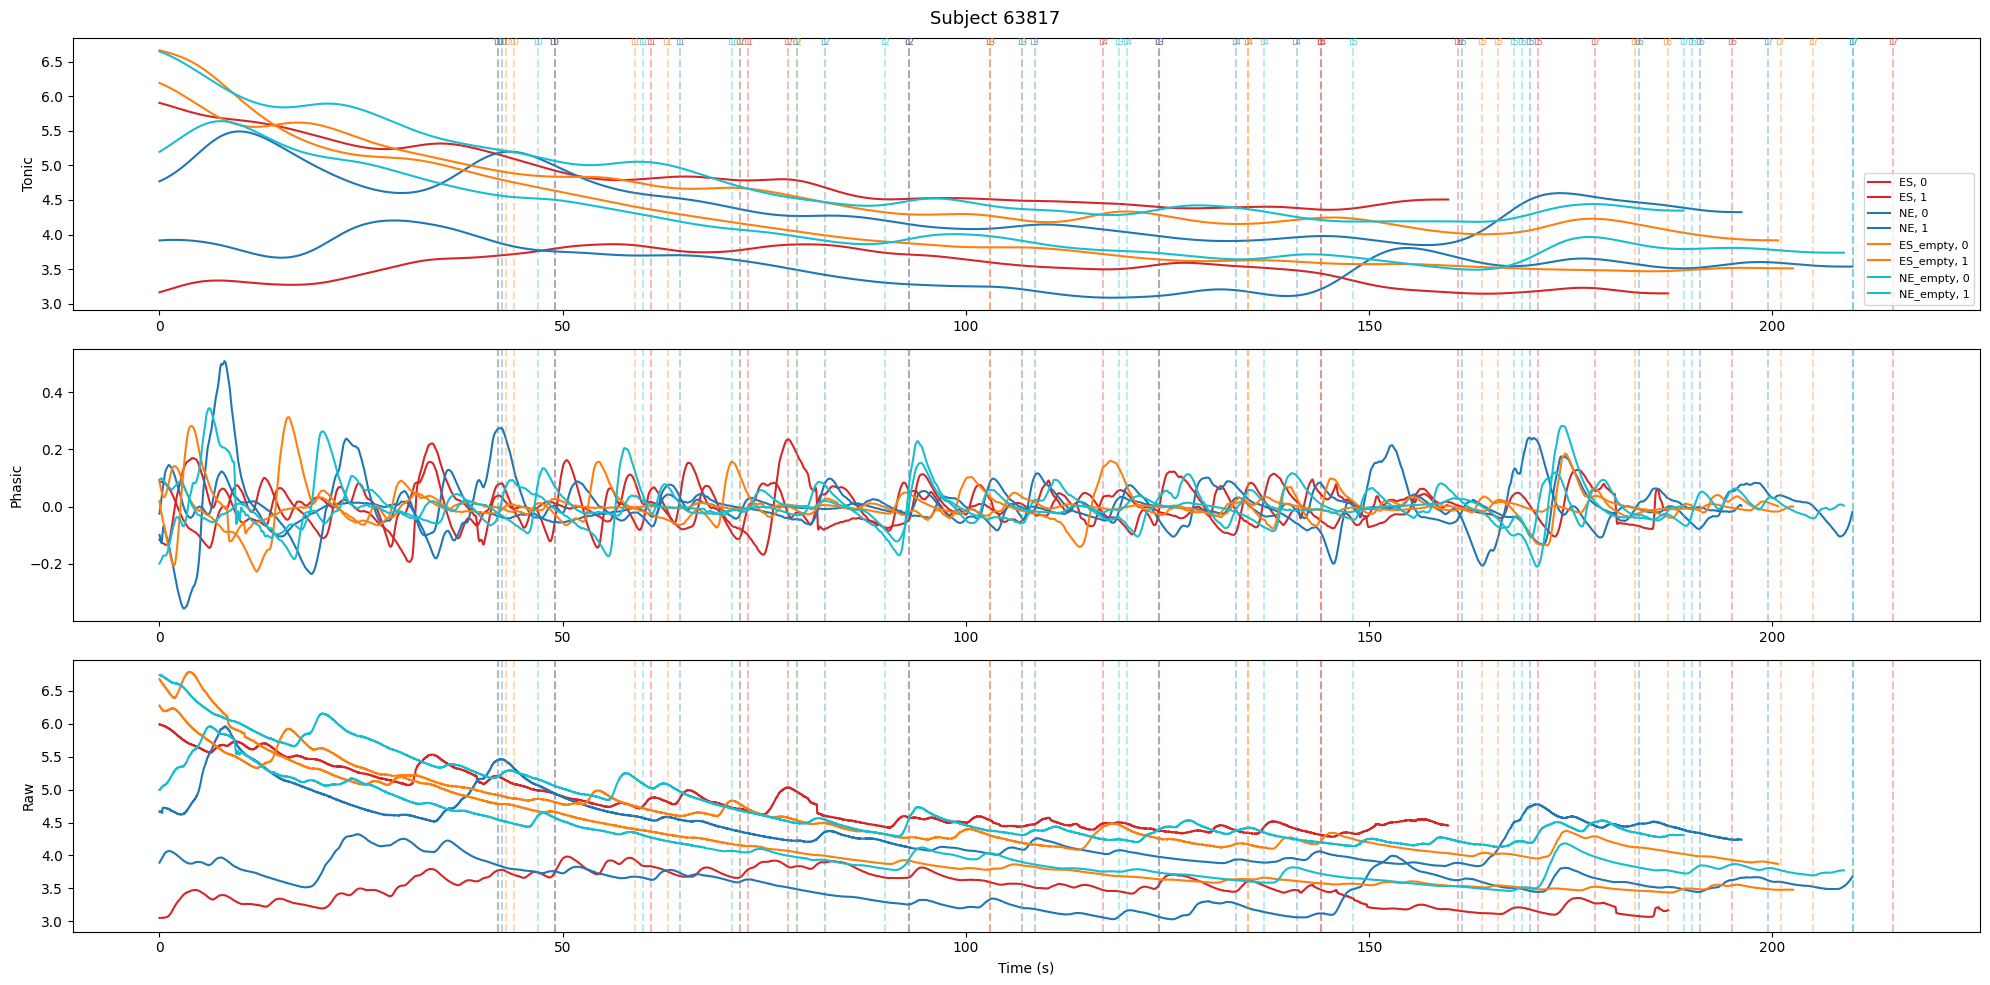

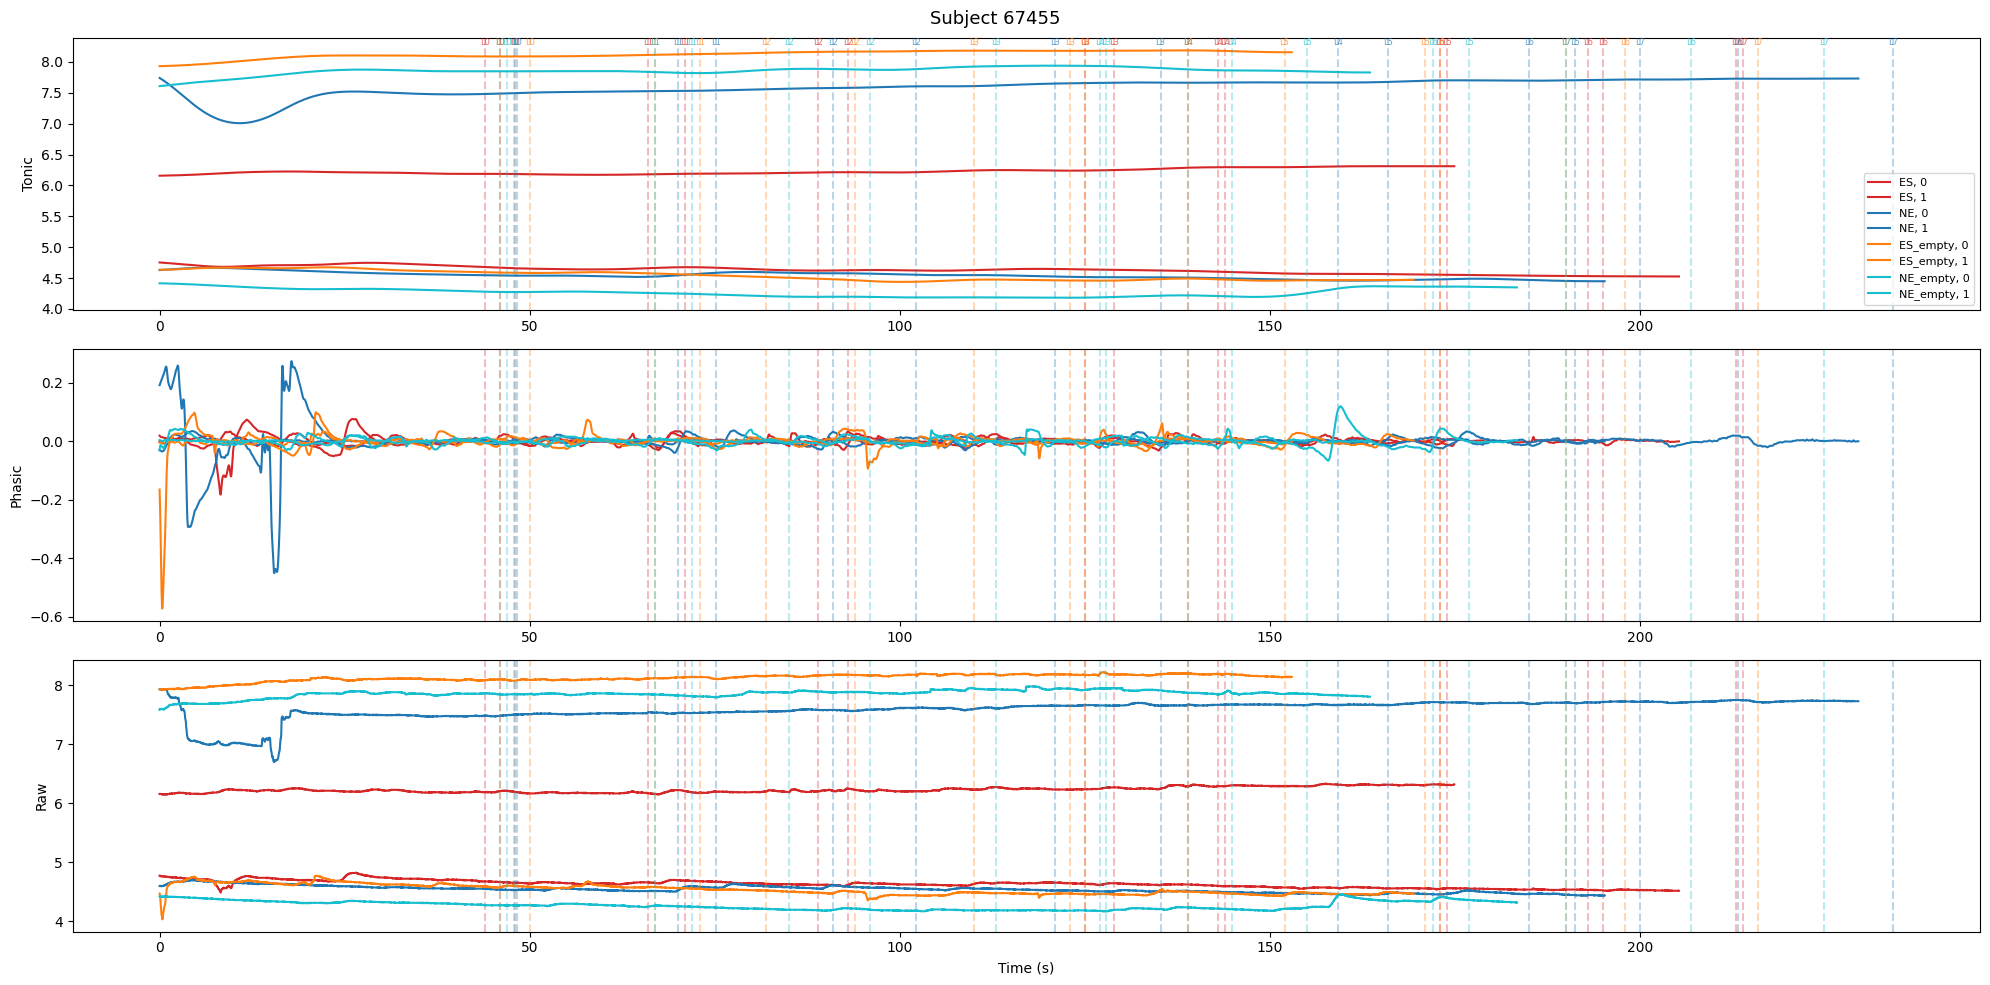

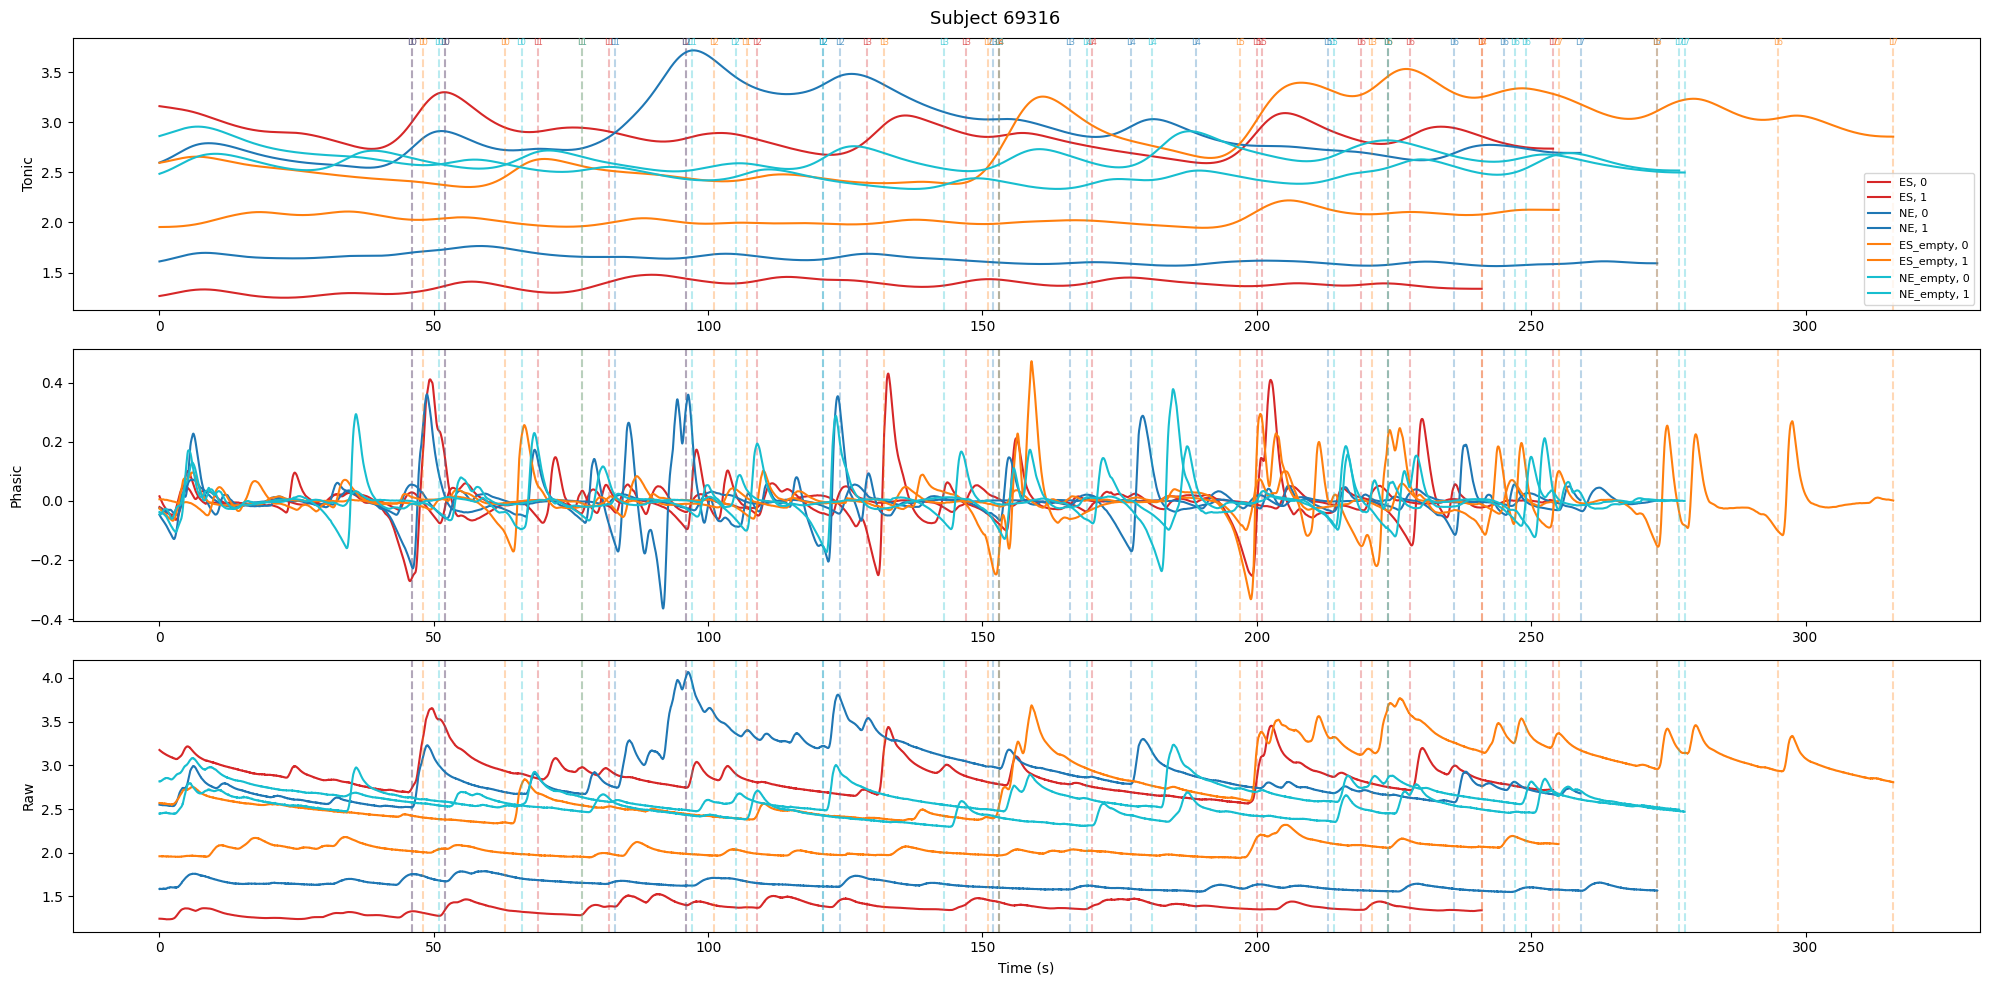

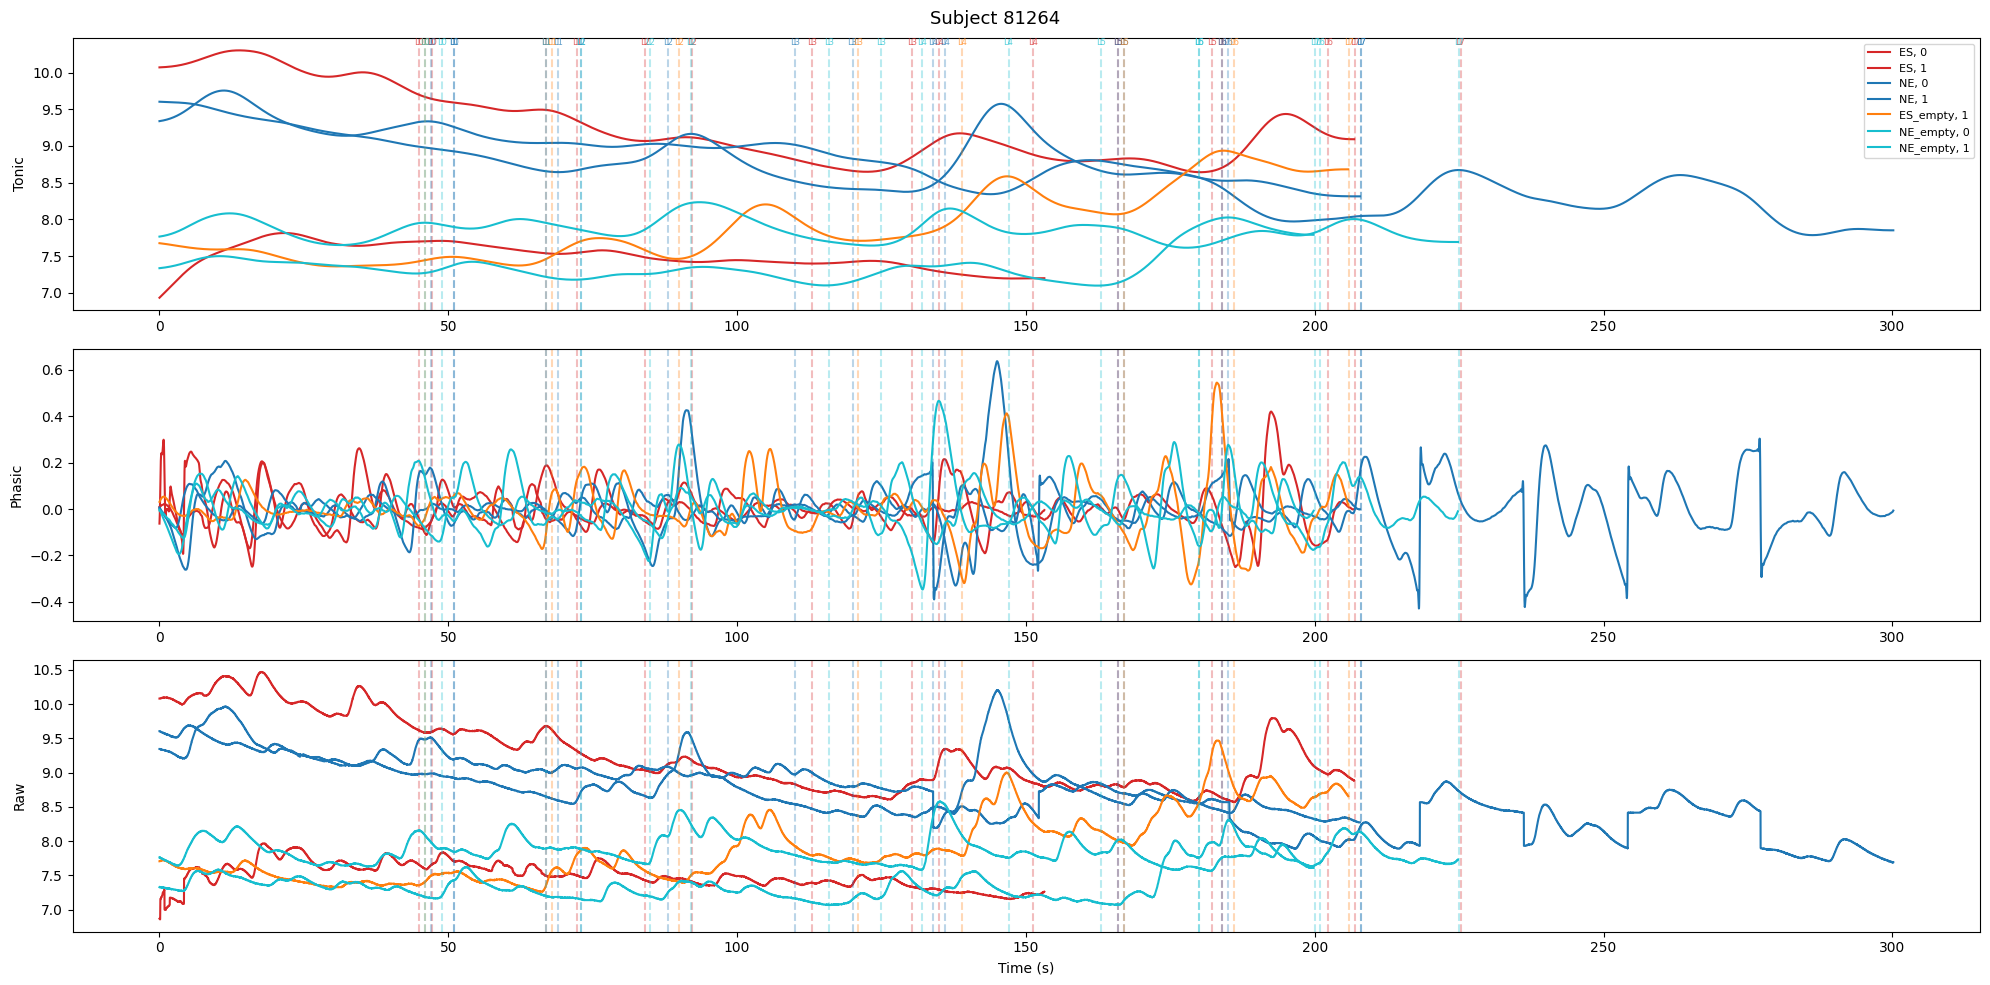

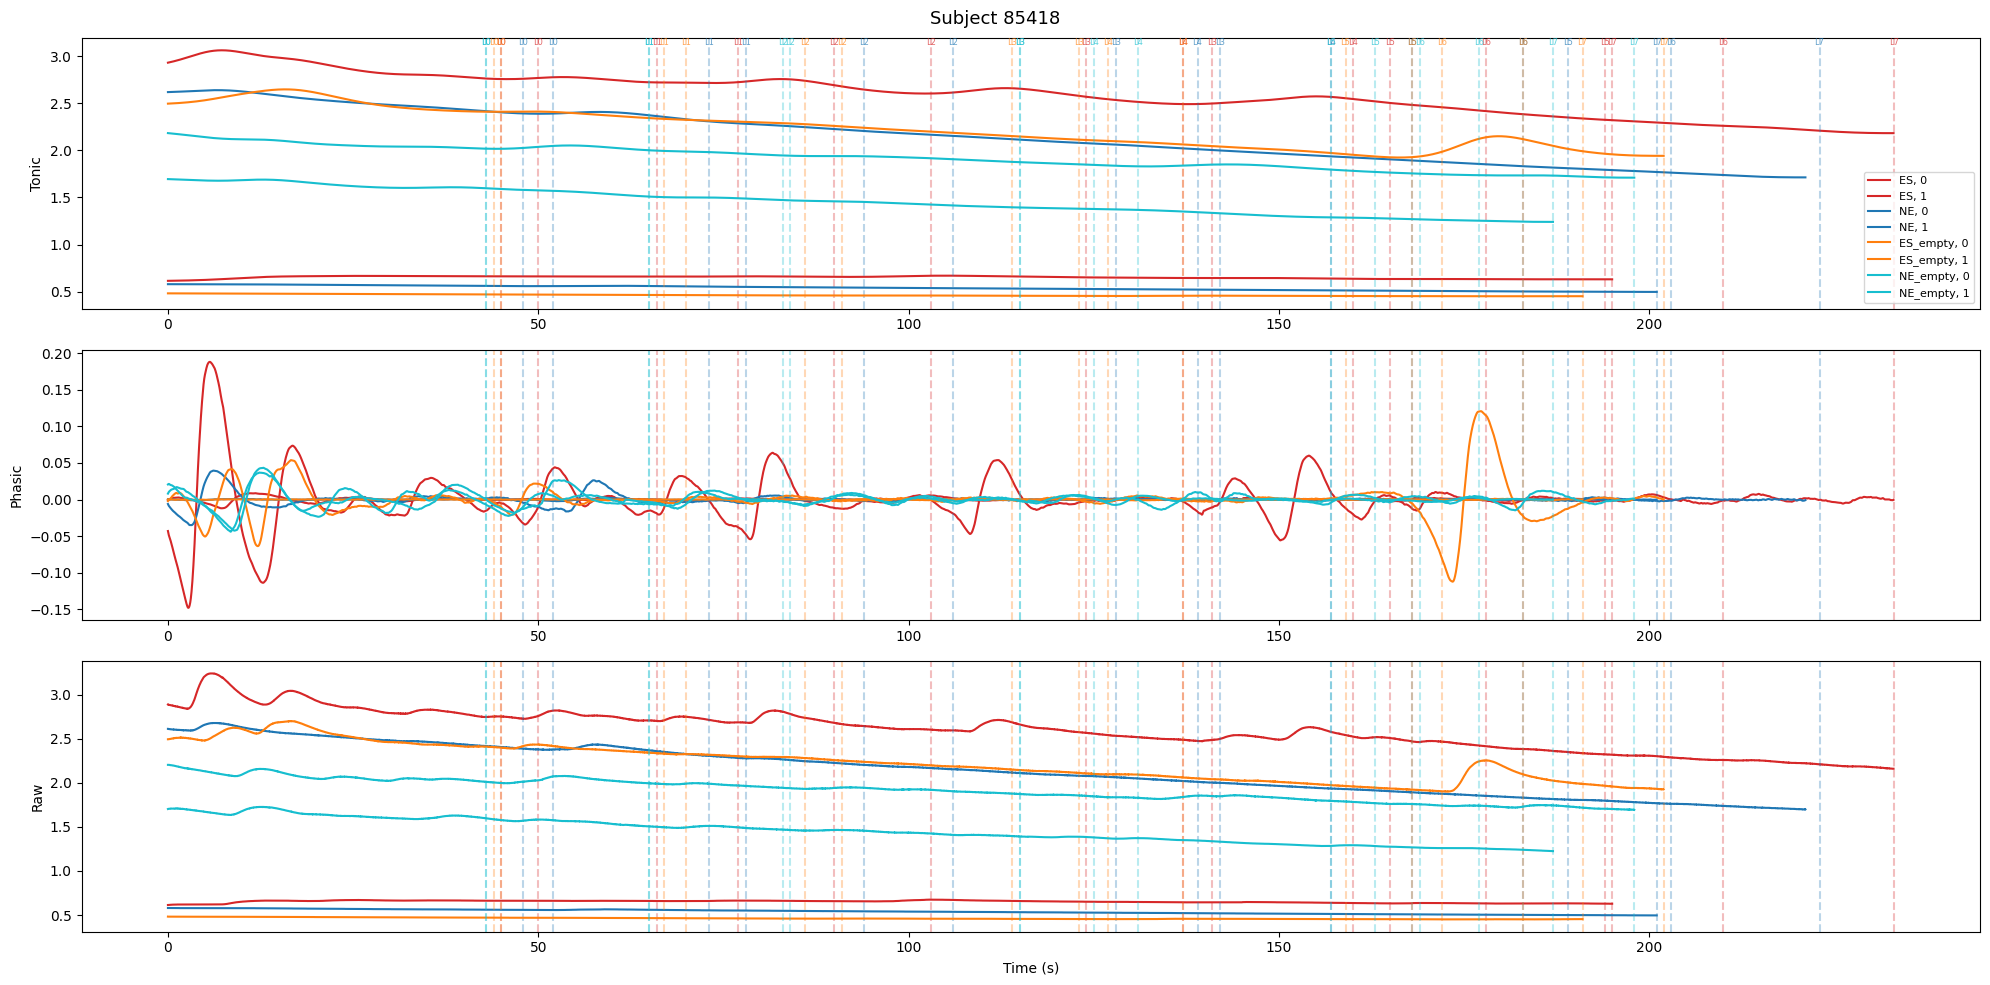

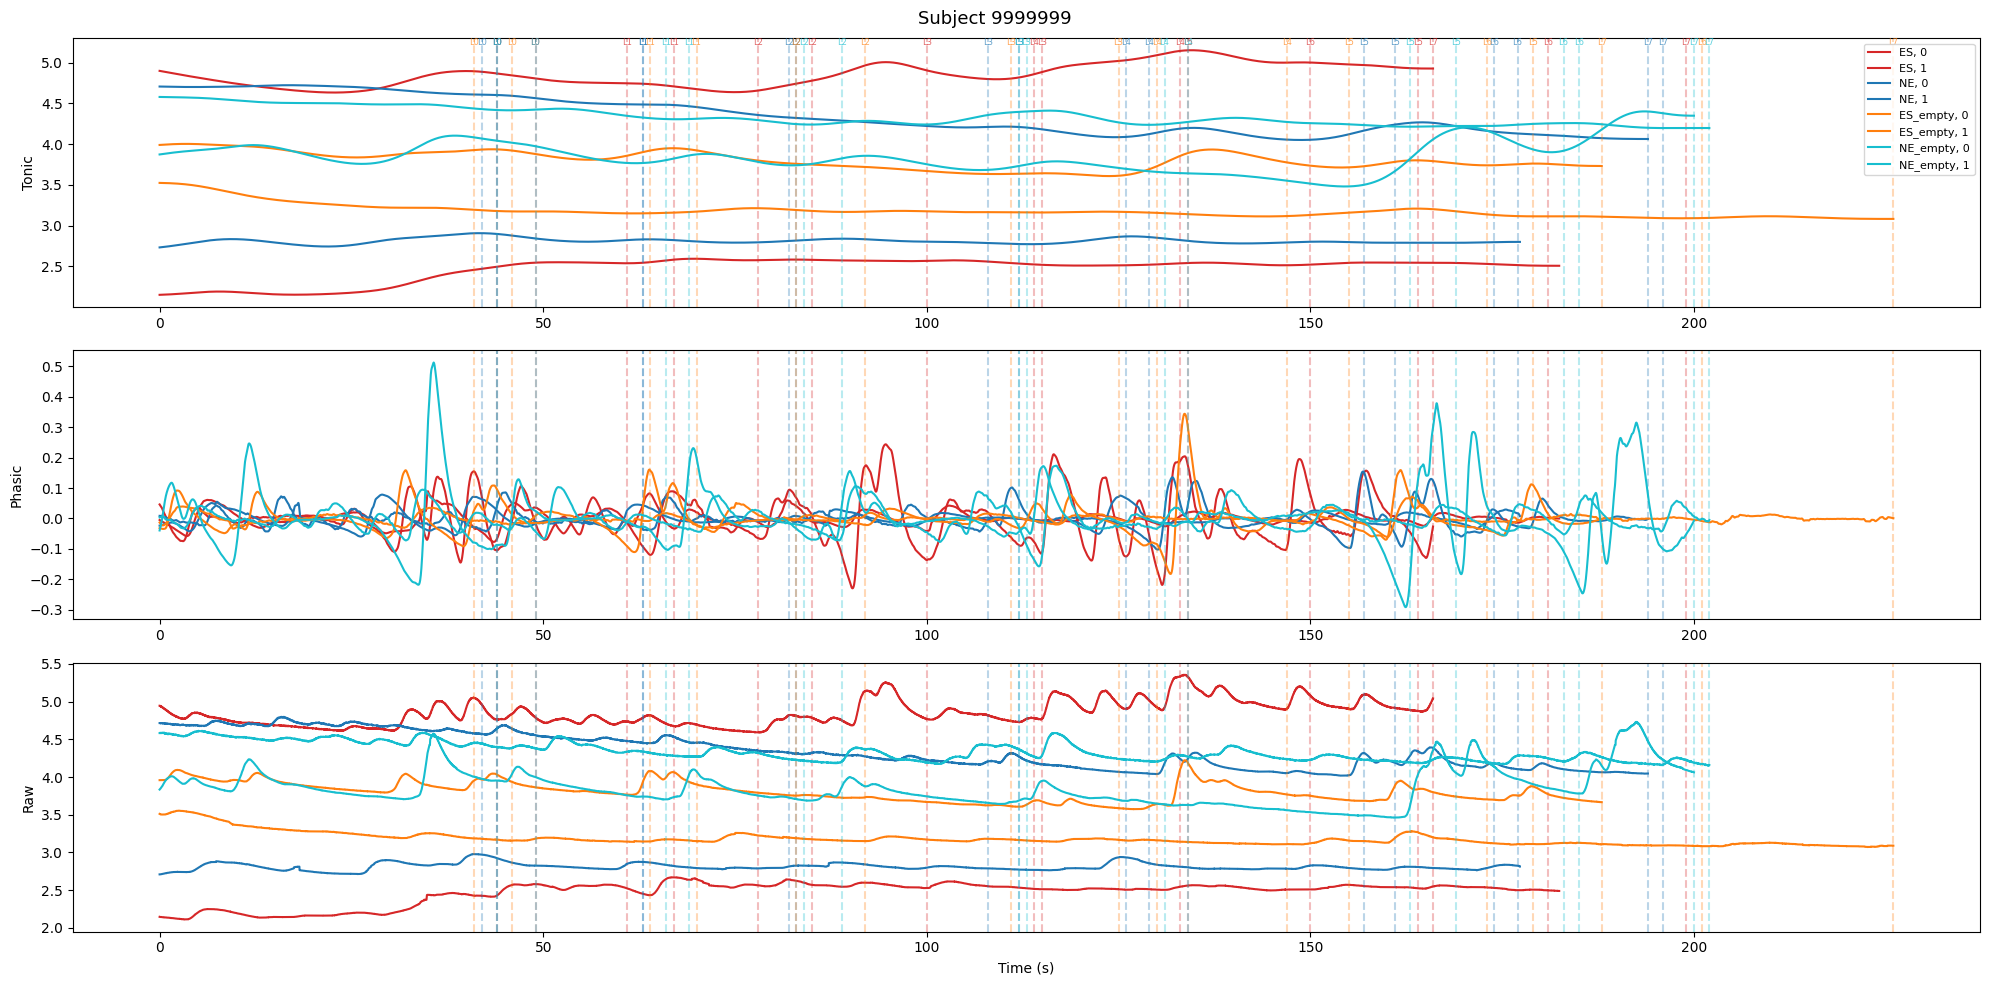

In [34]:
CONDITION_COLORS = {
    'ES':       'tab:red',
    'NE':       'tab:blue',
    'ES_empty': 'tab:orange',
    'NE_empty': 'tab:cyan',
}

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('eda_signals.pdf') as pdf:
    for subject_id, subject_df in all_subjects.items():
        level_intervals = parse_condition_intervals(subject_id)

        fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=False)
        fig.suptitle(f'Subject {subject_id}', fontsize=13)

        level_lines = []

        for condition, color in CONDITION_COLORS.items():
            for rep in [0, 1]:
                seg = subject_df[(subject_df['condition'] == condition) & (subject_df['rep'] == rep)]
                if len(seg) == 0:
                    continue
                try:
                    cleaned = clean_eda(seg[GSR_COL].values)
                    signals, _ = nk.eda_process(cleaned, sampling_rate=SAMPLING_RATE)
                    t = np.arange(len(seg)) / SAMPLING_RATE


                    
                    axes[0].plot(t, signals['EDA_Tonic'].values, color=color, label=f"{condition}, {rep}")
                    axes[1].plot(t, signals['EDA_Phasic'].values, color=color)
                    axes[2].plot(t, signals['EDA_Raw'].values, color=color)

                    levels = level_intervals[
                        (level_intervals['condition'] == condition) &
                        (level_intervals['rep'] == rep)
                    ].sort_values('level')

                    
                    if len(levels) > 0:
                        seg_start_ms = seg['Shimmer_A679_TimestampSync_Unix_CAL'].iloc[0]
                        for _, lvl in levels.iterrows():
                            t_level = (lvl['end'] - seg_start_ms) / 1000
                            for ax in axes:
                                ax.axvline(t_level, color=color, alpha=0.3, linestyle='--')
                            level_lines.append((t_level, color, int(lvl['level'])))

                except Exception as e:
                    print(f"Failed {subject_id} {condition} rep{rep}: {e}")

        top = axes[0].get_ylim()[1]
        for t_level, color, level_num in level_lines:
            axes[0].text(t_level, top, f"L{level_num}",
                         fontsize=6, color=color, alpha=0.7, ha='center', va='top')

        axes[0].set_ylabel('Tonic')
        axes[1].set_ylabel('Phasic')
        axes[2].set_ylabel('Raw')
        axes[2].set_xlabel('Time (s)')
        axes[0].legend(fontsize=8)
        plt.tight_layout()
        plt.show()
        pdf.savefig(fig, dpi=600)
        plt.close(fig)  # free memory after each subject
